# Unit 5 - Financial Planning

In [1447]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [1448]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [1449]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [1450]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [1451]:
# Fetch current BTC price
btc_data = requests.get(btc_url)

# Fetch current ETH price
eth_data = requests.get(eth_url)

# Compute current value of my crpto

# First, I will parse the data in JSON format to select only the price
# Then I store the price data in a variable
btc_value = btc_data.json()
btc_price = btc_value['data']['1']['quotes']['USD']['price']

#Then I create a variable based on the user's portfolio, by multipying the amount of crypto by the current price variable
my_btc_value = btc_price * my_btc

#The same process applies to the ETH data
eth_value = eth_data.json()
eth_price = eth_value['data']['1027']['quotes']['USD']['price']
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $53199.60
The current value of your 5.3 ETH is $16461.06


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [1452]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [1453]:

# Set Alpaca API key and secret
alpaca_key = os.getenv("ALPACA_API_KEY")
secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
from alpaca_trade_api.rest import REST, TimeFrame

alpaca = tradeapi.REST (
    alpaca_key,
    secret_key,
    api_version="v2"
)


In [1454]:
# Format current date as ISO format
today = pd.Timestamp("2022-03-21", tz="America/New_York").isoformat()


# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
#timeframe = '1D'

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
#df_tickers = alpaca.get_bars(
 #   tickers,
  #  TimeFrame.Day,
   # start=today,
    #end=today,
    #limit=1000,
#).df

#df_tickers.index = df_tickers.index.date
agg_close = pd.DataFrame()
agg_info = alpaca.get_bars("AGG", TimeFrame.Day, "2022-03-21", "2022-03-21", adjustment='raw').df
agg_close["AGG Close"] = agg_info["close"]
agg_close.index = agg_close.index.date

spy_close = pd.DataFrame()
spy_info = alpaca.get_bars("SPY", TimeFrame.Day, "2022-03-21", "2022-03-21", adjustment='raw').df
spy_close["SPY Close"] = spy_info["close"]
spy_close.index = spy_close.index.date

# Preview DataFrame
agg_close.head()
spy_close.head()


,SPY Close
2022-03-21,444.3


In [1455]:
# Pick AGG and SPY close prices
agg_close_price = agg_close["AGG Close"].iloc[0] 
spy_close_price = spy_close["SPY Close"].iloc[0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.04
Current SPY closing price: $444.3


In [1456]:
# Compute the current value of shares
my_agg_value = agg_close["AGG Close"].iloc[0] * my_agg
my_spy_value = spy_close["SPY Close"].iloc[0] * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22215.00
The current value of your 200 AGG shares is $21408.00


### Savings Health Analysis

In [1457]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
shares = my_agg_value + my_spy_value
crypto = my_btc_value + my_eth_value
assets_data = { "Amount": [shares, crypto]}
assets = ["Shares", "Crypto"]

# Create savings DataFrame
df_savings = pd.DataFrame(assets_data, index = assets)

# Display savings DataFrame
display(df_savings)



,Amount
Shares,43623.000
Crypto,69660.658


array([<AxesSubplot:ylabel='Amount'>], dtype=object)

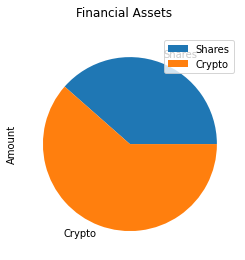

In [1458]:
# Plot savings pie chart
df_savings.plot.pie(subplots= True, title="Financial Assets")

In [1459]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = shares + crypto

difference = emergency_fund- total_savings

# Validate saving health
for amount in df_savings:
    if total_savings > emergency_fund:
        print("Congratulations! You have enough money in your savings!")
    elif total_savings == emergency_fund:
        print("Congratulations! You have reached your savings goal!")
    elif total_savings < emergency_fund:
        print(f"Hello! You are ${difference} away from reaching your savings goal!")

Congratulations! You have enough money in your savings!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [1460]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-03-21', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-03-21', tz='America/New_York').isoformat()

In [1461]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)

def get_company(ticker, start, end, tradeapi):
    return alpaca.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df
    

df_stock_data = {"SPY": get_company("SPY", start_date, end_date, tradeapi),
                 "AGG": get_company("AGG", start_date, end_date, tradeapi)}

stock_data = pd.concat(df_stock_data.values(), keys=df_stock_data.keys(), axis="columns")

# Display sample data
stock_data.head()

SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2017-03-21 04:00:00+00:00  237.49  237.61  233.58  233.73  131809275   
2017-03-22 04:00:00+00:00  233.73  234.61  233.05  234.28   97569204   
2017-03-23 04:00:00+00:00  233.98  235.34  233.60  234.03  100410277   
2017-03-24 04:00:00+00:00  234.35  235.04  232.96  233.86  112504853   
2017-03-27 04:00:00+00:00  231.97  233.92  231.61  233.62   87454452   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2017-03-21 04:00:00+00:00      443599  234.853857  107.93  108.27  107.9300   
2017-03-22 04:00:00+00:00      307469  233.932509  108.44  108.54  108.3600   
2017-03-23 04:00:00+00:00      333903  234.388790  108.44  108.51  108.2635   
2017-03-24 04:00:00+00:00      359600  234.080978  108.35  108.51  108.3100   
2017-03-27 04:00:00+00:00      289784  233.041576  108.65  108.71  108.5345   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2017-03-21 04:00:00+00:00  108.27  2049680       12024  108.175725  
2017-03-22 04:00:00+00:00  108.42  2643641       11111  108.455049  
2017-03-23 04:00:00+00:00  108.45  2071485       10901  108.417635  
2017-03-24 04:00:00+00:00  108.36  3374871       11229  108.398485  
2017-03-27 04:00:00+00:00  108.62  1977292       11112  108.600681

In [1462]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
from MCForecastTools import MCSimulation



In [1463]:
# Printing the simulation input data
print(stock_data)

                              SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2017-03-21 04:00:00+00:00  237.49  237.61  233.58  233.73  131809275   
2017-03-22 04:00:00+00:00  233.73  234.61  233.05  234.28   97569204   
2017-03-23 04:00:00+00:00  233.98  235.34  233.60  234.03  100410277   
2017-03-24 04:00:00+00:00  234.35  235.04  232.96  233.86  112504853   
2017-03-27 04:00:00+00:00  231.97  233.92  231.61  233.62   87454452   
...                           ...     ...     ...     ...        ...   
2022-03-15 04:00:00+00:00  419.66  426.84  418.42  426.17  104219651   
2022-03-16 04:00:00+00:00  429.94  435.68  424.80  435.55  138130298   
2022-03-17 04:00:00+00:00  433.70  441.07  433.19  441.07  100157174   
2022-03-18 04:00:00+00:00  437.81  444.86  437.22  444.31  102327793   
2022-03-21 04:00:00+00:00  444.45  446.46  440.68  444.30   8537

In [1464]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MCSim = MCSimulation(
    stock_data,
    weights = [.60, .40],
    num_simulation=500,
    num_trading_days=7560)

MCSim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996031,0.999645,1.000360,1.003304,0.994200,0.995414,1.016105,0.997561,0.985659,1.003787,...,0.987511,1.006994,1.006498,0.997531,0.999994,1.010456,0.986875,1.004915,1.008831,1.015084
2,0.997777,1.008972,1.011565,1.023031,0.995131,0.999871,1.010080,0.991314,0.970924,1.013574,...,0.988073,1.009953,1.002227,1.003301,0.999154,1.016857,0.988508,0.992023,1.006446,1.020642
3,0.995460,1.010926,1.009184,1.027128,0.994965,0.995734,1.004621,0.989138,0.977575,1.018631,...,0.992432,1.008044,1.011561,1.003845,1.003643,1.017553,0.979424,0.998322,1.007160,1.030534
4,0.993729,1.005657,0.998399,1.035021,1.007195,0.996079,0.997341,0.993022,0.993307,1.015373,...,0.990678,1.011539,1.017207,1.004335,0.997047,1.021741,0.968001,0.995466,1.004414,1.028858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.609955,12.012081,62.200132,46.958016,23.193259,26.869918,10.453712,11.270297,2.996052,44.016680,...,17.977221,6.324141,33.011914,11.549536,9.808987,6.287185,6.340307,10.463503,12.355313,24.860899
7557,6.593013,11.892324,61.734687,46.734062,22.662392,26.926525,10.388524,11.359547,3.010645,44.094179,...,17.866998,6.317673,33.042625,11.475229,9.848596,6.272550,6.352441,10.455237,12.328815,24.843129
7558,6.551165,11.807361,61.283297,46.493925,22.875880,27.080664,10.415077,11.244406,3.029140,43.685296,...,18.166696,6.305935,33.061812,11.398251,9.879866,6.371087,6.400057,10.354775,12.516588,25.292693
7559,6.534157,11.777557,60.768263,46.600491,22.825484,27.292614,10.423226,11.276776,3.025112,43.516836,...,18.294219,6.314329,32.918282,11.553220,9.909528,6.372763,6.431935,10.302009,12.470313,24.968207


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

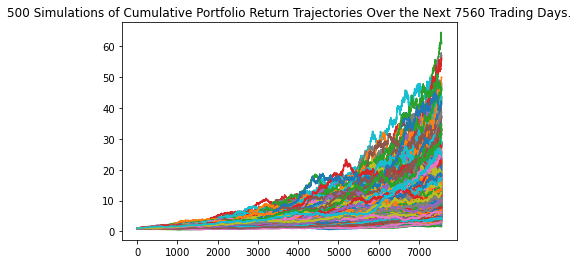

In [1465]:
# Plot simulation outcomes
MCSim.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

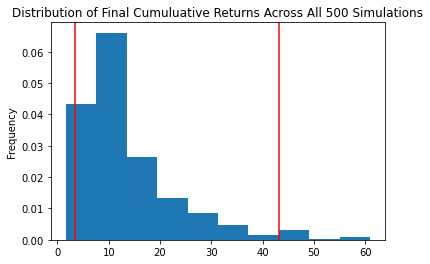

In [1466]:
# Plot probability distribution and confidence intervals
MCSim.plot_distribution()

### Retirement Analysis

In [1470]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_table = MCSim.summarize_cumulative_return()

# Print summary statistics
print(summary_table)

count           500.000000
mean             13.779730
std               9.621344
min               1.628087
25%               7.430551
50%              11.156193
75%              17.045974
max              60.937000
95% CI Lower      3.454501
95% CI Upper     43.137471
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [1471]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_table[8]*initial_investment,2)
ci_upper = round(summary_table[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $69090.03 and $862749.43


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [1472]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_table[8]*initial_investment,2)
ci_upper = round(summary_table[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $103635.04 and $1294124.14
